# Исходные данные

In [ ]:
from numpy import array, linspace
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.spatial import cKDTree
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import random
from collections import Counter
import time
from sklearn.metrics import mean_squared_error

## Ряд Лоренца

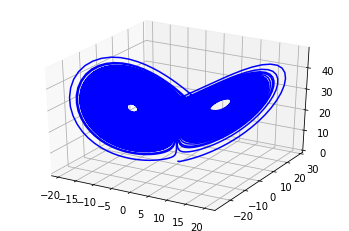

[ 1.21347378  1.01578349  0.84303088 ... -3.45731982 -3.75687885
 -4.08463552]
(9000,)


In [ ]:
def lorenz(t, x0):
    sigma = 10
    r = 28
    b = 8.0 / 3.0
    x, y, z = x0 
    fx = sigma * (y - x)
    fy = r * x - y - x * z
    fz = x * y - b * z
    return array([fx, fy, fz], float)

# начальная точка
x0 = [0, 1, 0]
# решение системы методов Рунге-Кутта 4 порядка
sol = solve_ivp(lorenz, [0, 140], x0, t_eval=linspace(0, 140, 14000))

fig = pylab.figure()
ax = pylab.axes(projection="3d")
ax.plot3D(sol.y[0,:], sol.y[1,:], sol.y[2,:], 'blue')
pylab.show()

data_lorenz = sol.y[0,:]
data_lorenz = data_lorenz[5000:]  # обрезаем первые 5000 точек
print(data_lorenz)
print(data_lorenz.shape)

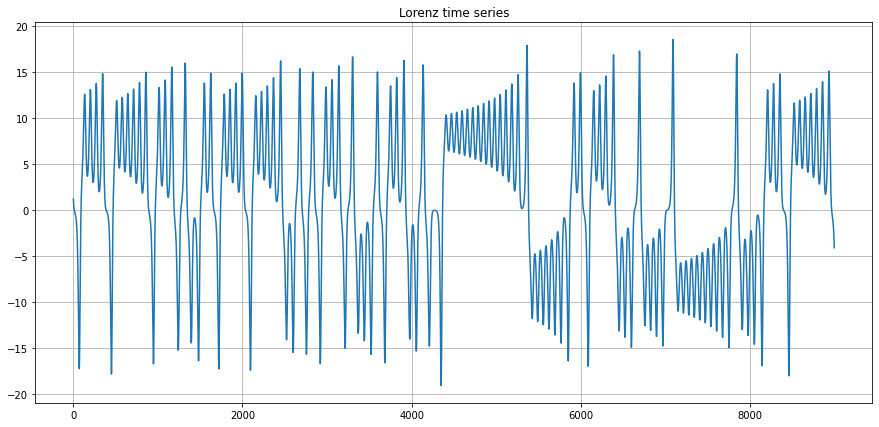

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(data_lorenz)
plt.title('Lorenz time series')
plt.grid(True)
plt.show()

## Финансовый ряд

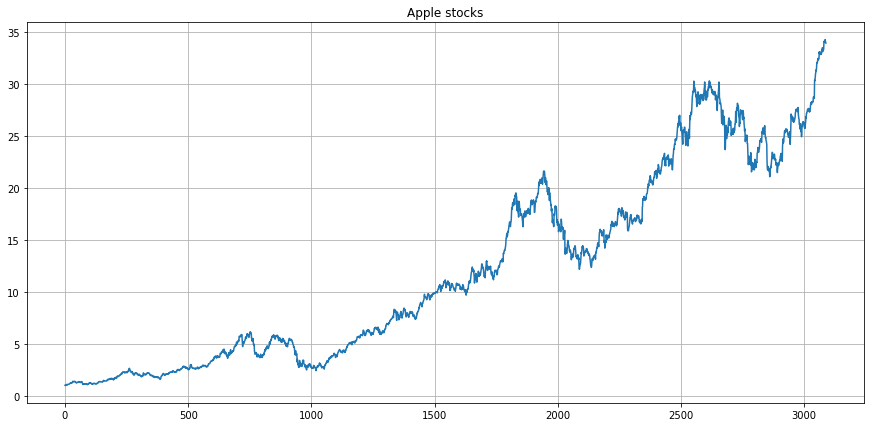

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv')
data_fin = dataset.loc[:, 'Adj Close']
plt.figure(figsize=(15, 7))
plt.plot(data_fin)
plt.title('Apple stocks')
plt.grid(True)
plt.show()

In [ ]:
data_fin.shape

(3089,)

In [ ]:
data1diff = data_fin.diff(periods=1).dropna()

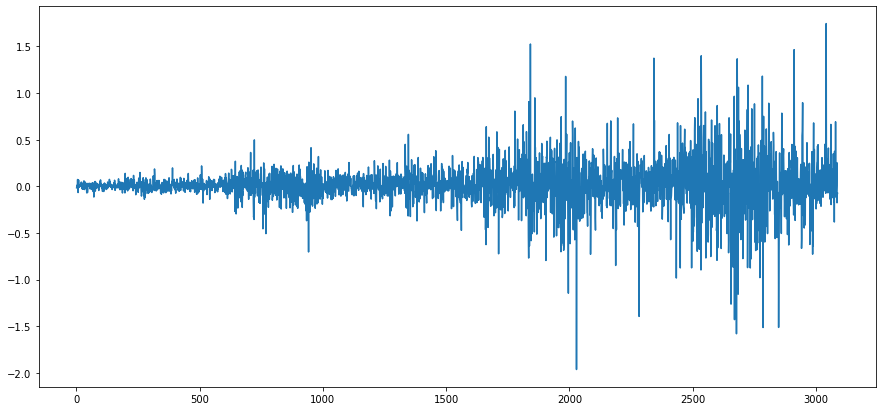

In [ ]:
data1diff.plot(figsize=(15, 7))

In [ ]:
data_fin = data1diff.to_list()

# Вычисление старшего показателя Ляпунова методом Розенштейна

In [ ]:
def get_z_vectors(x, m, tau):
    n = len(x)
    k = n - (m - 1) * tau
    z = np.zeros((k, m))
    for i in range(k):
        z[i] = np.array([x[i + j * tau] for j in range(m)])
    return z


def get_nearest_neighbors(z, k):
    tree = cKDTree(z)  # конструируем дерево траекторий
    n_rows = len(z)
    indices = np.zeros(n_rows, dtype=int)
    for i in range(n_rows):
        idx = tree.query(z[i], k=k+1, p=2)[1][k]
        indices[i] = idx
    return indices


def MLE(time_series, tau, m, k=1):
    z = get_z_vectors(time_series, m, tau)
    z_cnt = z.shape[0]
    z_pruned = z[:z_cnt-m]

    nn_indices = get_nearest_neighbors(z_pruned, k)
    
    lambda_estimate = np.zeros(len(z_pruned))
    for j in range(len(z_pruned)):
        x = z[j]
        x_nn = z[nn_indices[j]]
        dist = np.linalg.norm(x - x_nn, ord=2)
        delta = dist

        x_k = z[j + k]
        x_nn_k = z[nn_indices[j] + k]
        dist_k = np.linalg.norm(x_k - x_nn_k, ord=2)
        eps = dist_k

        lambda_estimate[j] = (1/k) * np.log(eps / delta)

    l_exp = np.mean(lambda_estimate)
    return l_exp

Значение старшего показателя Ляпунова для системы Лоренца

In [ ]:
m = 4
m_exp_lorenz = MLE(data_lorenz, 1, m)
print(m_exp_lorenz)

0.11799113360779664


Значение старшего показателя Ляпунова для финансового ряда

In [ ]:
m = 4
m_exp_fin = MLE(data_fin, 1, m)
print(m_exp_fin)

0.9745672011389342


# Плоскость энтропия-сложность


In [ ]:
def get_probabilities(x, m, tau):
    num_of_permutations = math.factorial(m)
    perm_list = []
    time_series = x[::tau]
    n = len(time_series)

    for i in range(n - m + 1):
        permutation = list(np.argsort(time_series[i : (m + i)]))
        perm_list.append(permutation)

    elements, frequency = np.unique(np.array(perm_list), return_counts = True, axis = 0)
    relative_frequency = np.divide(frequency, (n - tau * (m - 1)))

    if len(relative_frequency) != num_of_permutations:
        relative_frequency_pad = np.pad(relative_frequency, (0, int(num_of_permutations - len(relative_frequency))), mode = 'constant')
        return relative_frequency_pad
    else:
        return relative_frequency


def shannon_entropy(probabilities):
    entropy = 0.0
    for p in probabilities:
        if p != 0.0:
            entropy += p * np.log(p)
    return -entropy


def normalized_entropy(probabilities):
    entropy = 0.0
    max_entropy = np.log(len(probabilities))
    for p in probabilities:
        if p != 0.0:
            entropy += p * np.log(p)
    return -entropy/max_entropy


def complexity(probabilities):
    N = len(probabilities)
    norm_entropy = normalized_entropy(probabilities)
    
    C1 = (N + 1)/N * np.log(N + 1)
    C2 = 2 * np.log(2*N)
    C3 = np.log(N)
    Q0 = -2 * (1/(C1 - C2 + C3))

    p_uniform = []
    for i in range(N):
        p_uniform.append(1/N)

    p_sum = [p + pe for p, pe in zip(probabilities, p_uniform)]
    JS_div = shannon_entropy(np.divide(p_sum, 2.0)) - 0.5 * shannon_entropy(probabilities) - 0.5 * shannon_entropy(p_uniform)
    jensen_shannon_complexity = Q0 * JS_div * norm_entropy
    return jensen_shannon_complexity


def CH_plane(data, m, tau):
    probabilities = get_probabilities(data, m, tau)
    entropy = normalized_entropy(probabilities)
    compl = complexity(probabilities)

    return compl, entropy


def min_line(n_steps, m):
    N = math.factorial(m)
    m_step = (1 - 1/N) / (n_steps)
    min_complexity_entropy_x = []
    min_complexity_entropy_y = []
    p_min = list(np.arange(1/N, 1, m_step))
    for n in range(len(p_min)):
        P_minimize = []
        if p_min[n] > 1:
            p_min[n] = 1
        P_minimize.append(p_min[n])
        for i in range(N - 1):
            p_rest = (1 - p_min[n]) / (N - 1)
            P_minimize.append(p_rest)

        P_minimize = np.array(P_minimize)

        min_complexity_entropy_x.append(normalized_entropy(P_minimize))
        min_complexity_entropy_y.append(complexity(P_minimize))

    return min_complexity_entropy_x, min_complexity_entropy_y


def max_line(n_steps, m):
    N = math.factorial(m)
    m_step = (1 - 1/N) / (n_steps)
    max_complexity_entropy_x = []
    max_complexity_entropy_y = []
    for n in range(N - 1):
        p_max = list(np.arange(0, 1 / (N - n), m_step))

        for m in range(len(p_max)):
            P_maximize = list()
            P_maximize.append(p_max[m])
            p_rest = (1 - p_max[m]) / (N - n - 1)
            for i in range(N - n - 1):
                P_maximize.append(p_rest)

            if len(P_maximize) != N:
                P_maximize = np.pad(P_maximize, (0, n), mode = 'constant')

            P_maximize = np.array(P_maximize)

            max_complexity_entropy_x.append(normalized_entropy(P_maximize))
            max_complexity_entropy_y.append(complexity(P_maximize))

    return max_complexity_entropy_x, max_complexity_entropy_y

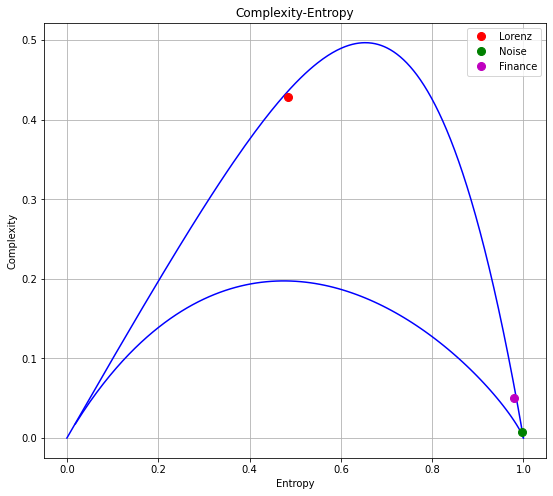

In [ ]:
n = 20000
noise = [random.gauss(0,1) for i in range(n)]
noise = np.array(noise)

m = 6

C_lorenz, H_lorenz = CH_plane(data_lorenz, m, 8)
C_noise, H_noise = CH_plane(noise, m, 1)
C_fin, H_fin = CH_plane(data_fin, m, 1)

minimum_line = min_line(100, m)
maximum_line = max_line(1, m)

plt.figure(figsize = (9,8))
plt.title('Complexity-Entropy')
plt.plot(minimum_line[0], minimum_line[1], color = 'blue')
plt.plot(maximum_line[0], maximum_line[1], color = 'blue')
plt.plot(H_lorenz, C_lorenz, 'ro', markersize = 8, label = 'Lorenz')
plt.plot(H_noise, C_noise, 'go', markersize = 8, label = 'Noise')
plt.plot(H_fin, C_fin, 'mo', markersize = 8, label = 'Finance')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xlabel('Entropy')
plt.ylabel('Complexity')
plt.legend()
plt.grid()
plt.show()

# Прогнозирование на основе кластеризации

## Версия 1

In [ ]:
def get_p(x_i, dist, n, k):
    volume_x = (4/3) * math.pi * (dist ** 3)
    return k / (n * volume_x)


def is_significant(points, cluster_points, h, k):
    n = len(points)
    p = []
    for i in range(len(cluster_points)):
        x_i = cluster_points[i]
        dist_x_i = points[x_i][1]
        for j in range(i+1, len(cluster_points)):
            x_j = cluster_points[j]
            dist_x_j = points[x_j][1]
            p_i_j = math.fabs(get_p(x_i, dist_x_i, n, k) - get_p(x_j, dist_x_j, n, k))
            p.append(p_i_j)
    if len(p) == 1:
        if p[0] >= h:
            return True
    if max(p) >= h:
        return True
    return False


def data_perform(data):
    data_points = [[0, x] for x in data]
    return data_points


def get_distance(data, k):
    # для каждого x_i получаем индекс k-ближайшего соседа
    nn_data = get_nearest_neighbors(data, k)
    # print('nn_data:', nn_data)

    # считаем расстояние d_k(x_i)
    N = len(data)
    dist = np.zeros(N)
    for i in range(N):
        dist[i] = np.linalg.norm(np.array(data[i]) - np.array(data[nn_data[i]]), ord=2)

    # помещаем это в словарь, данные лежат в виде {i: [x_i, d_x(x_i)]}
    points_with_dist = {}
    for i in range(N):
        points_with_dist[i] = [data[i][1], dist[i]]

    return points_with_dist


def sort_distances(data_dict):
    # преобразуем в список
    list_d = list(data_dict.items())

    # сортировка по возрастанию d_x(x_i)
    list_sorted = list_d.copy()
    list_sorted.sort(key=lambda i: i[1][1])
    return list_sorted


def get_predict_vectors(x, m, tau):
    n = len(x)
    num_rows = n - (m - 1) * tau
    z = np.zeros((num_rows, m))
    for i in range(num_rows):
        z[i] = np.array([x[i + j * tau] for j in range(m)])
    z = [list(z_i) for z_i in z]
    return z

In [ ]:
def wishart_clustering(data, k, h):
    data_performed = data_perform(data)
    distance_dict = get_distance(data_performed, k)  # {i: [x_i, d_x(x_i)]}
    list_sorted = sort_distances(distance_dict)  # [sorted: (i, [x_i, d_x(x_i)]) ]

    v_0 = list_sorted[0][0]
    Vi = [v_0]
    clusters_count = 1
    w = {}  # список кластеров в виде {i: wi}, где wi - номер кластера вершины x_i
    w[v_0] = 1

    signific_w = {}

    completed_w = {}
    completed_w[0] = False
    completed_w[clusters_count] = False

    for i in range(1, len(data)):
        cur_i = list_sorted[i][0]  # индекс cur x_i
        cur_xi = data_performed[cur_i]  # [индекс, значение] cur x_i

        cur_ei = []  # список вершин, связанных ребрами с x_i 
        # ищем те x_j, в окрестностях которых находится x_i и добавляем ребра
        for x in Vi:
            j = x  # индекс x_j
            x_j = data_performed[j] # [индекс, значение] for x_j
            dist_xj = distance_dict[x][1]  # расстояние x_j

            dist_xi_xj = np.linalg.norm(np.array(cur_xi) - np.array(x_j), ord=2)
            if dist_xi_xj <= dist_xj:
                cur_ei.append(j)
        Vi.append(cur_i)

        # вершина x_i изолирована
        if len(cur_ei) == 0:
            clusters_count += 1
            w[cur_i] = clusters_count
            completed_w[clusters_count] = False
        
        # вершина x_i связана ребрами с вершинами x_j
        else:
            nn_clusters_x_j = {}  # {j: w[x_j]}, j - индекс вершины x_j
            for ei in cur_ei:
                if ei in w:
                    nn_clusters_x_j[ei] = w[ei]
                else:
                    continue

            list_of_clusters = list(nn_clusters_x_j.values())  # [l_0, l_1, ..., l_s]
            num_of_diff_clusters = dict(Counter(list_of_clusters))  # количество кластеров одного типа в виде {l_i: count(l_i)}

            # если все вершины x_j принадлежат одному кластеру
            if len(num_of_diff_clusters) == 1:
                cur_clstr = list_of_clusters[0]
                if completed_w[cur_clstr] is True:
                    w[cur_i] = 0
                else:
                    w[cur_i] = cur_clstr

            # если вершины x_j принадлежат разным кластерам из списка l_0, l_1, ..., l_s
            else:
                all_clustrs_compl = True
                for l_i in nn_clusters_x_j:
                    if completed_w[nn_clusters_x_j[l_i]] is False:
                        all_clustrs_compl = False
                        break
                
                if all_clustrs_compl:
                    w[cur_i] = 0
                    continue

                # сортируем nn_clusters_x_j по возрастанию l_0 <= l_1 <= ... <= l_s
                sorted_nn_clusters_x_j = dict(sorted(nn_clusters_x_j.items(), key=lambda item: item[1]))  # sorted {j: w[x_j]}, j - индекс вершины x_j

                z_h = 0  # количество кластеров значимых по h
                
                # для каждого кластера из проверяем, является ли он значимым
                cur_signific = []
                set_sorted_nn_clusters = set(sorted_nn_clusters_x_j.values())
                for cluster_l in set_sorted_nn_clusters:
                    if cluster_l == 0 :
                        continue
                    l_points = [x for x in w if w[x] == cluster_l]
                    if len(l_points) > 1 and is_significant(distance_dict, l_points, h, k):
                        signific_w[cluster_l] = True
                        z_h += 1
                        cur_signific.append(cluster_l)
                
                l_0 = min(set_sorted_nn_clusters)
                if (l_0 == 0) or (z_h > 1):
                    w[cur_i] = 0
                    for sing_clstrs in cur_signific:
                        completed_w[sing_clstrs] = True
                    for not_sign_clstrs in set_sorted_nn_clusters.difference(set(cur_signific)):  # все незначимые кластера (т.е. множество всех - множество значимых)
                        for x in w:
                            if w[x] == not_sign_clstrs:
                                w[x] = 0

                if (l_0 != 0) and (z_h == 1):
                    w[cur_i] = cur_signific[0]
                    for x in sorted_nn_clusters_x_j:
                        w[x] = cur_signific[0]
        
        if w.get(cur_i) is None:
            w[cur_i] = 0

    return w

In [ ]:
def predict_v1(w, points, n_test, s):
    m = s + 1  # количество точек в паттернах для предсказания
    
    z_w = get_predict_vectors(w, m, 1)  # делим w на паттерны
    z_points = get_predict_vectors(points, m, 1)  # делим вектор со значениям точек на паттерны
    
    n_train = len(w)  # количество тренировочного набора данных

    test_points = []  # список выходных точек
    
    for i in range(n_train):
        test_points.append([points[i]])  # список значений вершин

    pattern_contains_all_none = False
    for i in range(n_test):  # 0, 1, ..., n_test-1
        cur_predict_x = []

        is_none = False
        none_counts = 0
        
        z_vector = z_w[-1][1:]
        point_vector = z_points[-1][1:]

        z_indexes = [x for x in range(len(z_w))]

        for j in range(s):  # 0, 1, ..., s-1
            z_j = z_vector[j]           
            if z_j is None:
                none_counts += 1
                if none_counts == s:
                    pattern_contains_all_none = True
                    break
                continue
            
            cur_z_indexes = []
            for k in z_indexes:  # z_0, z_1, ...
                if z_w[k][j] == z_j:
                    cur_z_indexes.append(k)
            z_indexes = cur_z_indexes

            if len(z_indexes) == 0:
                is_none = True
                break
        
        if pattern_contains_all_none is True:
            return test_points

        if is_none is True:
            cur_predict_x = None
            
            cur_z_vector = z_vector.copy()
            cur_z_vector.append(cur_predict_x)
            z_w.append(cur_z_vector)
            
            cur_x = point_vector.copy()
            cur_x.append(cur_predict_x)
            z_points.append(cur_x)
            
            test_points.append(cur_predict_x)
        else:
            for i in z_indexes:
                z_w_i = z_w[i][-1]
                cur_z_vector = z_vector.copy()
                cur_z_vector.append(z_w_i)
                z_w.append(cur_z_vector)

                x_i = z_points[i][-1]
                cur_x = point_vector.copy()
                cur_x.append(x_i)
                z_points.append(cur_x)

                cur_predict_x.append(x_i)
            test_points.append(cur_predict_x)

    return test_points

### Прогнозирование для ряда Лоренца

In [ ]:
n_lorenz_train = 8000
n_lorenz_test = 1000
h = 0.5  # параметр для определения значимости кластера
k = 5  # номер ближайшего соседа

In [ ]:
data_lorenz_train = data_lorenz[:n_lorenz_train]
data_lorenz_test = data_lorenz[n_lorenz_train:]

Кластеризация

In [ ]:
start_time = time.time()

w_lorenz = wishart_clustering(data_lorenz_train, k, h)

print("%s seconds" % (time.time() - start_time))

497.83617210388184 seconds


In [ ]:
len(w_lorenz)

8000

Прогнозирование

In [ ]:
s_array = [3, 4, 6, 8, 10, 12]  # количество точек для предсказания следующей точки
points_l_array = []

for s in s_array:
    print('s:', s)
    start_time = time.time()
    points_lorenz = predict_v1(w_lorenz, data_lorenz_train, n_lorenz_test, s)
    print("%s seconds" % (time.time() - start_time))
    points_l_array.append(points_lorenz)

s: 3
36.439223289489746 seconds
s: 4
2.249046802520752 seconds
s: 6
1.608461856842041 seconds
s: 8
1.7810299396514893 seconds
s: 10
1.6539828777313232 seconds
s: 12
1.7505898475646973 seconds


Результат прогнозирования для s = 10

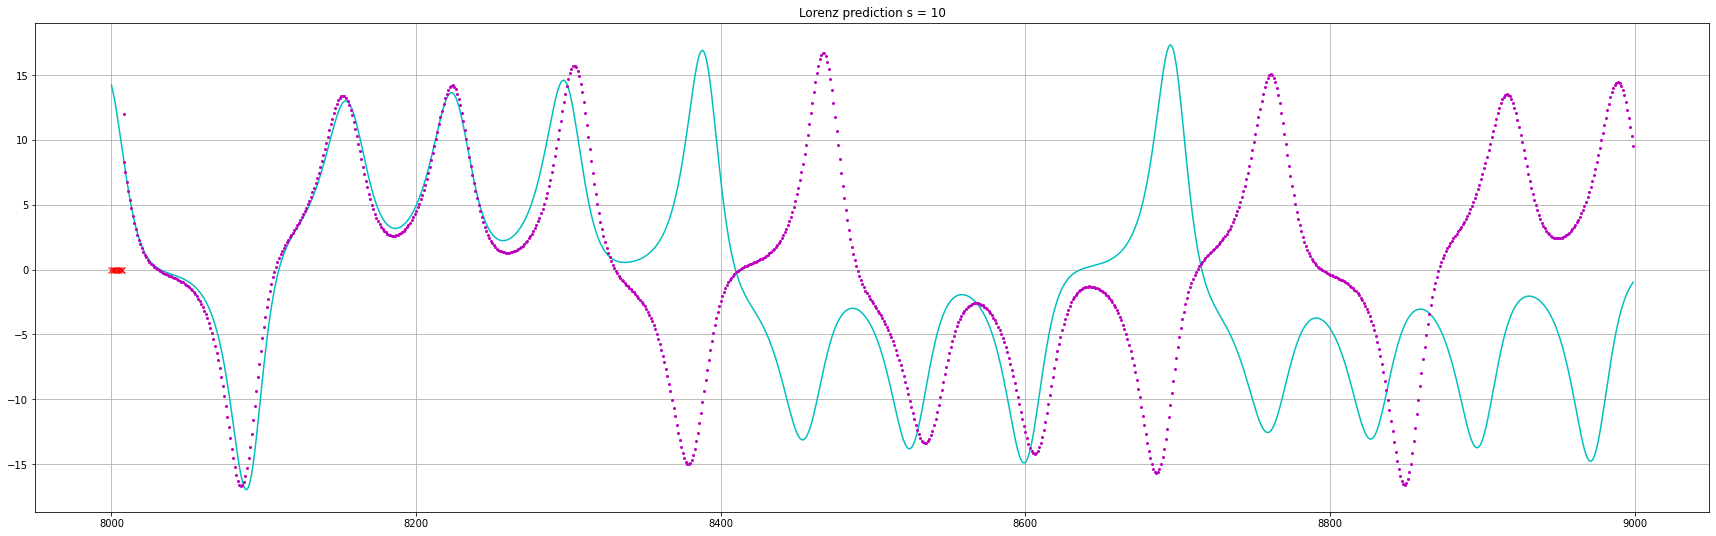

In [ ]:
plt.figure(figsize = (30, 9))
plt.title('Lorenz prediction s = 10')
plt.plot(range(n_lorenz_train, n_lorenz_train + n_lorenz_test), data_lorenz[n_lorenz_train:], 'c')
for i in range(n_lorenz_train, n_lorenz_train + n_lorenz_test):
    point = points_l_array[4][i]  # s = 10
    if point is None:
        plt.plot(i, 0, 'r', marker = 'x')
    else:
        for x in point:
            if x is None:
                continue
            plt.plot(i, x, 'm', marker = 'o', ms=2)
plt.grid()
plt.show()

In [ ]:
indefenite_points_count = []  # количество непрогнозируемых точек для разных s
for p in points_l_array:
    indefenite_points_count.append(p.count(None))

In [ ]:
indefenite_points_percent = []
for p in indefenite_points_count:
    indefenite_points_percent.append((p / n_lorenz_test) * 100)

In [ ]:
predicted_vals_array = []
for pred in points_l_array:
    cur_predict_val = []
    for x in pred[n_lorenz_train:]:
        if x is None:
            predicted_values_lorenz = [0]
        elif None in x:
            predicted_values_lorenz = [0]
        else:
            predicted_values_lorenz = [np.mean(x)]
        cur_predict_val.append(predicted_values_lorenz)
    predicted_vals_array.append(cur_predict_val)

MAPE, RMSE и количество непрогнозируемых точек для каждого значения параметра s

In [ ]:
rmse_array_lor = []
mape_array_lor = []
for i in range(len(s_array)):
    mse_lorenz = mean_squared_error(data_lorenz_test, predicted_vals_array[i])
    rmse_lorenz = math.sqrt(mse_lorenz)
    rmse_array_lor.append(rmse_lorenz)

    mape = 0.0
    for j in range(n_lorenz_test):
        if data_lorenz_test[j] != 0.0:
            mape += math.fabs((data_lorenz_test[j] - predicted_vals_array[i][j]) / data_lorenz_test[j])
    res_mape = (1 / n_lorenz_test) * mape
    mape_array_lor.append(res_mape)

    print('s:', s_array[i])
    print('amount of indefenite points:', indefenite_points_count[i])
    print('MAPE:', res_mape)
    print('RMSE:', rmse_lorenz)

s: 3
amount of indefenite points: 1
MAPE: 4.204297202279627
RMSE: 12.229995734132396
s: 4
amount of indefenite points: 2
MAPE: 5.727035757643516
RMSE: 10.896263908966286
s: 6
amount of indefenite points: 4
MAPE: 4.090278948200894
RMSE: 10.334603902768098
s: 8
amount of indefenite points: 6
MAPE: 4.321912554620942
RMSE: 10.222847157000812
s: 10
amount of indefenite points: 8
MAPE: 1.6506661257889361
RMSE: 10.504742083296287
s: 12
amount of indefenite points: 10
MAPE: 6.836232414449743
RMSE: 10.161317561857217


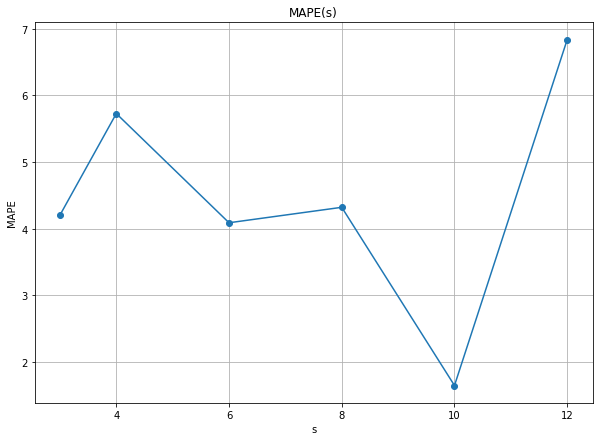

MAPE Square = 21.310158194618975


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('MAPE(s)')
plt.plot(s_array, mape_array_lor, marker = 'o')
plt.xlabel('s')
plt.ylabel('MAPE')
plt.grid()
plt.show()

print('MAPE Square =', np.trapz(mape_array_lor, dx=1))

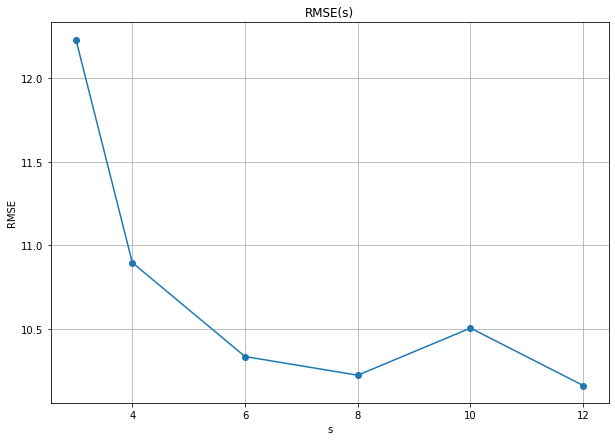

RMSE Square = 53.154113700026286


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('RMSE(s)')
plt.plot(s_array, rmse_array_lor, marker = 'o')
plt.xlabel('s')
plt.ylabel('RMSE')
plt.grid()
plt.show()

print('RMSE Square =', np.trapz(rmse_array_lor, dx=1))

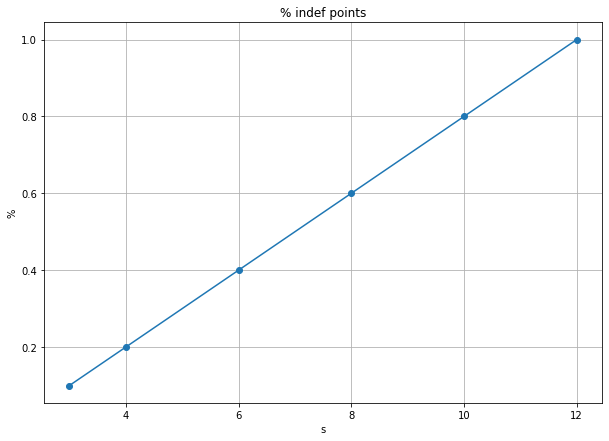

NP Square = 2.55


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('% indef points')
plt.plot(s_array, indefenite_points_percent, marker = 'o')
plt.xlabel('s')
plt.ylabel('%')
plt.grid()
plt.show()

print('NP Square =', np.trapz(indefenite_points_percent, dx=1))

### Прогнозирование для финансового ряда

In [ ]:
n_fin_train = 2088
n_fin_test = 1000
h_fin = 0.2  # параметр для определения значимости кластера
k_fin = 3  # номер ближайшего соседа

In [ ]:
data_fin_train = data_fin[:n_fin_train]
data_fin_test = data_fin[n_fin_train:]

In [ ]:
start_time = time.time()

w_fin = wishart_clustering(data_fin_train, k_fin, h_fin)

print("%s seconds" % (time.time() - start_time))

31.574765920639038 seconds


In [ ]:
len(w_fin)

2088

In [ ]:
s_array_fin = [3, 4, 6, 8, 10, 12]  # количество точек для предсказания следующей точки
points_l_array_fin = []

for s in s_array_fin:
    print('s:', s)
    start_time = time.time()
    points_fin = predict_v1(w_fin, data_fin_train, n_fin_test, s)
    print("%s seconds" % (time.time() - start_time))
    points_l_array_fin.append(points_fin)

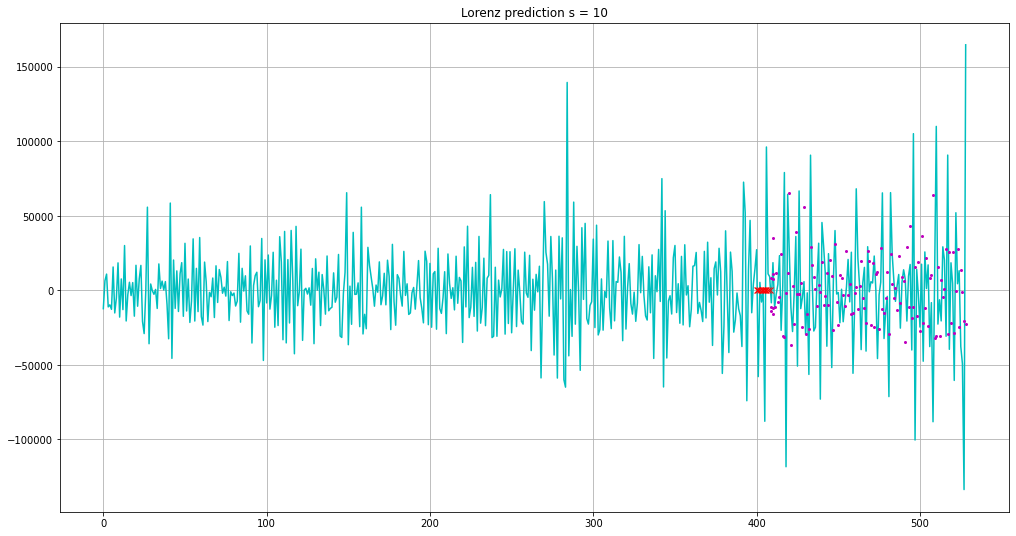

In [ ]:
plt.figure(figsize = (17, 9))
plt.title('Finance data prediction s = 10')
plt.plot(data_otg, 'c')
plt.plot(range(n_fin_train, n_fin_train + n_fin_test), data_fin[n_lorenz_train:], 'c')
for i in range(n_fin_train, n_fin_train + n_fin_test):
    point = points_l_array_otg[4][i]  # s = 10
    if point is None:
        plt.plot(i, 0, 'r', marker = 'x')
    else:
        for x in point:
            if x is None:
                continue
            plt.plot(i, x, 'm', marker = 'o', ms=2)
plt.grid()
plt.show()

In [ ]:
indefenite_points_count_otg = []  # количество непрогнозируемых точек для разных s
for p in points_l_array_otg:
    indefenite_points_count_otg.append(p.count(None))

In [ ]:
predicted_vals_array_otg = []
for pred in points_l_array_otg:
    cur_predict_val = []
    for x in pred[n_otg_train:]:
        if x is None:
            predicted_values = [0]
        elif None in x:
            predicted_values = [0]
        else:
            predicted_values = [np.mean(x)]
        cur_predict_val.append(predicted_values)
    predicted_vals_array_otg.append(cur_predict_val)

In [ ]:
rmse_array_otg = []
for i in range(len(s_array_otg)):
    mse_otg = mean_squared_error(data_otg_test, predicted_vals_array_otg[i])
    rmse_otg = math.sqrt(mse_otg)
    print('s:', s_array_otg[i])
    print('amount of indefenite points:', indefenite_points_count_otg[i])
    print('RMSE:', rmse_otg)
    rmse_array_otg.append(rmse_otg)

s: 3
amount of indefenite points: 2
RMSE: 56688.9668992259
s: 4
amount of indefenite points: 3
RMSE: 53653.270469787465
s: 6
amount of indefenite points: 5
RMSE: 50446.60409209878
s: 8
amount of indefenite points: 7
RMSE: 48944.10980192509
s: 10
amount of indefenite points: 9
RMSE: 48535.01235143102
s: 12
amount of indefenite points: 11
RMSE: 49556.780712760374


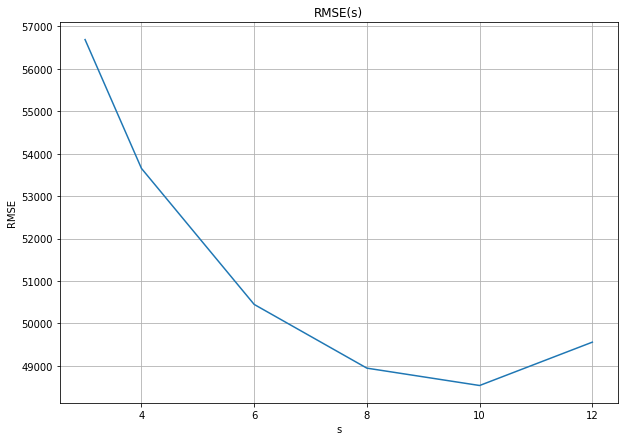

In [ ]:
plt.figure(figsize = (10, 7))
plt.title('RMSE(s)')
plt.plot(s_array_otg, rmse_array_otg)
plt.xlabel('s')
plt.ylabel('RMSE')
plt.grid()
plt.show()

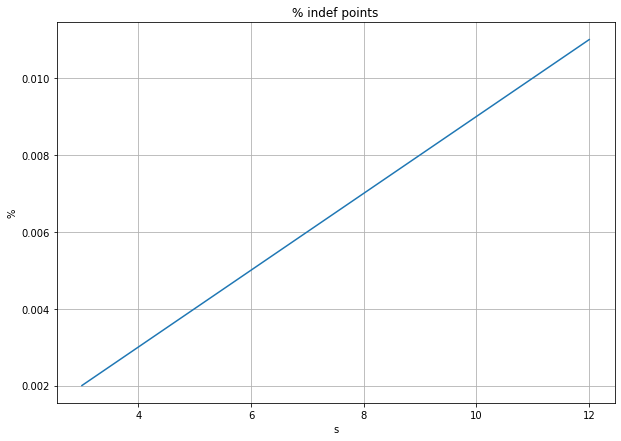

In [ ]:
s_array = [3, 4, 6, 8, 10, 12]
indef_p = [0.002, 0.003, 0.005, 0.007, 0.009, 0.011]
plt.figure(figsize = (10, 7))
plt.title('% indef points')
plt.plot(s_array, indef_p)
plt.xlabel('s')
plt.ylabel('%')
plt.grid()
plt.show()

## Версия 2

In [ ]:
def predict(w, points, n_test, n_train, s, h):
    # points - все точки
    # w - список кластеров для всех точек
    # n_test - количество точек тестовой выборки
    # n_train - количество точек обучающей выборки
    # s - количество точек для прогнозирования (размер паттерна)
    # h - шаг прогнозирования (1, 2, 3, ..., 10 шагов)
    
    m = s + h  # размер z-векторов

    predicted_points = []
    
    z_w = get_predict_vectors(w, m, 1)  # делим w на паттерны
    z_points = get_predict_vectors(points, m, 1)  # делим вектор со значениям точек на паттерны

    start_pattern_idx = n_train - m  # номер паттерна, с которго начинаем прогноз
    for i in range(n_test):
        pattern_idx = start_pattern_idx + i
        pattern = z_w[pattern_idx][:s]

        z_indexes = [x for x in range(pattern_idx)]
        
        cur_pred_points = []
        for j in range(s):
            cur_indexes = []
            for k in z_indexes:
                cur_z_w = z_w[k][j]
                cur_z_points = z_points[k]
                if cur_z_w == pattern[j]:
                    cur_indexes.append(k)
                z_indexes = cur_indexes
            if len(z_indexes) == 0:
                break

        if len(z_indexes) != 0:
            cur_pred_points = [z_points[ind][-1] for ind in z_indexes]
        
        if len(cur_pred_points) == 0:
            predicted_points.append(None)
        else:
            predicted_points.append(cur_pred_points)

    return predicted_points


def process_predict_data(raw_predicted_points):
    result = list()
    for i in range(len(raw_predicted_points)):
        if raw_predicted_points[i] is None:
            result.append(0)
        else:
            result.append(np.mean(raw_predicted_points[i]))
    return result


def amount_of_non_pred_and_pres(points):
    non_pred_count = 0
    pred_count = 0
    for p in points:
        if p is None:
            non_pred_count += 1
        else:
            pred_count += 1
    assert non_pred_count + pred_count == len(points), "Amount of non-predictable and predictable points should be equal to amount af all points"
    return non_pred_count, pred_count

### Для ряда Лоренца

In [ ]:
n_lorenz_train = 8000
n_lorenz_test = 1000

mu = 0.2  # параметр для определения значимости кластера
k = 7  # ближайший сосед
s = 2  # количество точек в паттерне для предсказания

In [ ]:
data_lorenz_train = data_lorenz[:n_lorenz_train]
data_lorenz_test = data_lorenz[n_lorenz_train:]

In [ ]:
start_time = time.time()

w_lorenz = wishart_clustering(data_lorenz, k, mu)

print("%s seconds" % (time.time() - start_time))

524.9732127189636 seconds


In [ ]:
len(w_lorenz)

9000

In [ ]:
h_array = [1, 2, 3, 5, 7, 10]
predicted_lorenz_array = []
for h in h_array:
    start_time = time.time()
    predicted_lorenz = predict(w_lorenz, data_lorenz, n_lorenz_test, n_lorenz_train, s, h)
    predicted_lorenz_array.append(predicted_lorenz)
    print("%s seconds" % (time.time() - start_time))

2.696974515914917 seconds
2.8060741424560547 seconds
2.9684417247772217 seconds
4.20002818107605 seconds
3.4862399101257324 seconds
3.9396181106567383 seconds


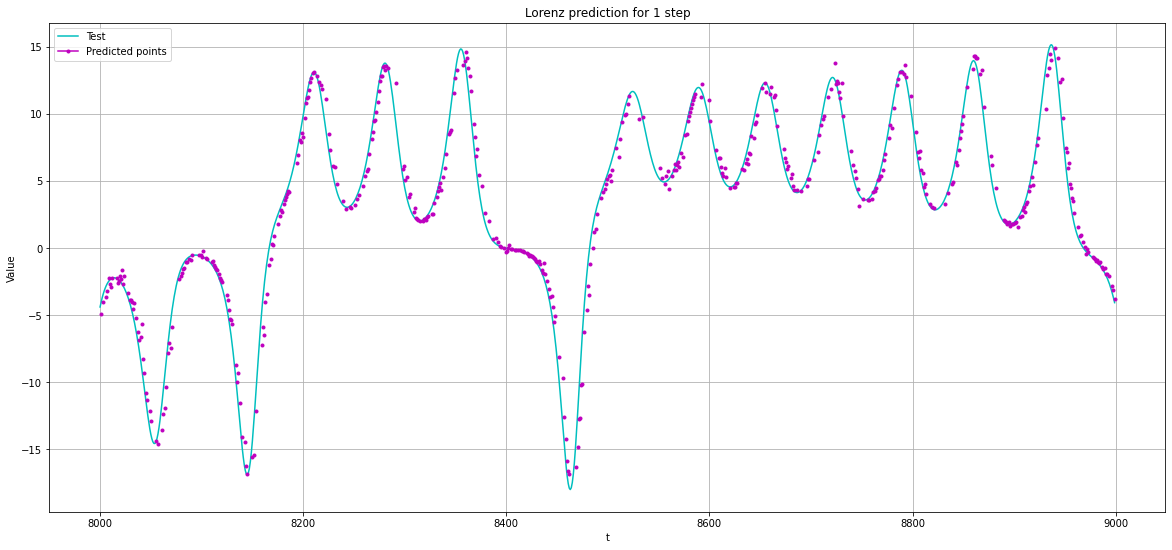

In [ ]:
plt.figure(figsize = (20, 9))
plt.title('Lorenz prediction for 1 step')
line1, = plt.plot(range(n_lorenz_train, n_lorenz_train + n_lorenz_test), data_lorenz[n_lorenz_train:], 'c')
idx = 0
for i in range(n_lorenz_train, n_lorenz_train + n_lorenz_test):
    point = predicted_lorenz_array[0][idx]
    if point is not None:
        # line2, = plt.plot(i, 0, 'r', marker = 'x')
    # else:
        # for x in point:
        #     if x is None:
        #         continue
        mean_point = np.mean(point)
        if len(point) < 10:
            line3, = plt.plot(i, mean_point, 'm', marker = 'o', ms=3)
    idx += 1
plt.legend([line1, line3], ['Test', 'Predicted points'], fontsize=10)
plt.grid()
plt.xlabel('t')
plt.ylabel('Value')
plt.show()

In [ ]:
non_pred_array_lorenz = []
pred_array_lorenz = []
for points in predicted_lorenz_array:
    non_pred_cnt, pred_cnt = amount_of_non_pred_and_pres(points)
    # print(non_pred_cnt, pred_cnt)
    non_pred_array_lorenz.append(non_pred_cnt)
    pred_array_lorenz.append(pred_cnt)

np_percent_array_lorenz = []
pred_percent_array_lorenz = []
for non_pred in non_pred_array_lorenz:
    np_percent_array_lorenz.append((non_pred / n_lorenz_test) * 100)
for pred in pred_array_lorenz:
    pred_percent_array_lorenz.append((pred / n_lorenz_test) * 100)

In [ ]:
mape_array_lorenz = []
rmse_array_lorenz = []
for points in predicted_lorenz_array:
    p = process_predict_data(points)
    
    mse = mean_squared_error(data_lorenz_test, p)
    rmse = math.sqrt(mse)
    # print('RMSE:', rmse)
    rmse_array_lorenz.append(rmse)

    mape = 0.0
    for i in range(n_lorenz_test):
        mape += math.fabs((data_lorenz_test[i] - p[i]) / data_lorenz_test[i])
    res_mape = (1 / n_lorenz_test) * mape
    # print('MAPE:', res_mape)
    mape_array_lorenz.append(res_mape)

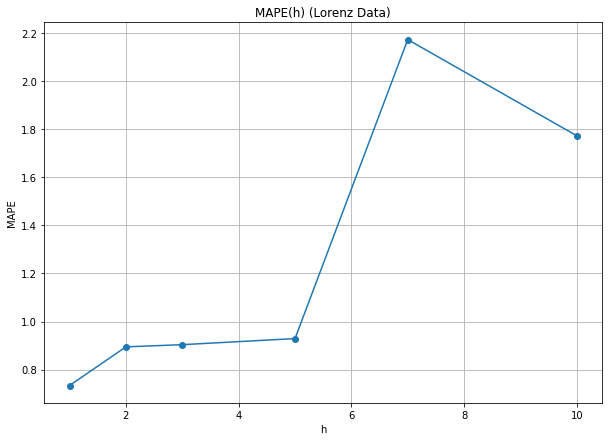

MAPE Square = 12.57015536305563


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('MAPE(h) (Lorenz Data)')
plt.plot(h_array, mape_array_lorenz, marker = 'o')
plt.xlabel('h')
plt.ylabel('MAPE')
plt.grid()
plt.show()

print('MAPE Square =', np.trapz(mape_array_lorenz, x=h_array))

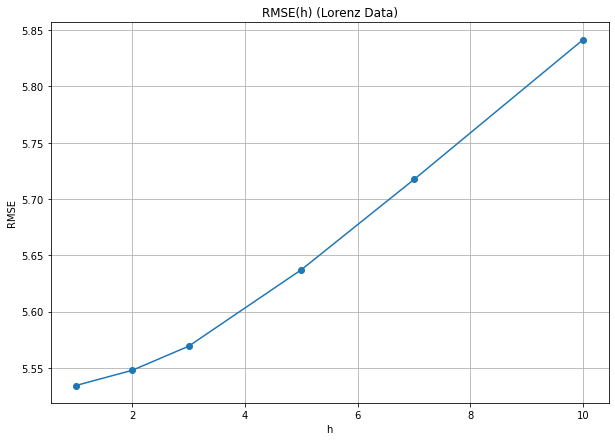

RMSE Square = 50.99900482484474


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('RMSE(h) (Lorenz Data)')
plt.plot(h_array, rmse_array_lorenz, marker = 'o')
plt.xlabel('h')
plt.ylabel('RMSE')
plt.grid()
plt.show()

print('RMSE Square =', np.trapz(rmse_array_lorenz, x=h_array))

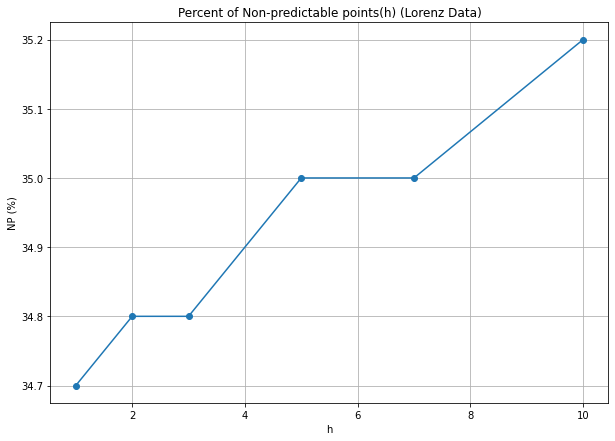

NP Square = 314.65


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('Percent of Non-predictable points(h) (Lorenz Data)')
plt.plot(h_array, np_percent_array_lorenz, marker = 'o')
plt.xlabel('h')
plt.ylabel('NP (%)')
plt.grid()
plt.show()

print('NP Square =', np.trapz(np_percent_array_lorenz, x=h_array))

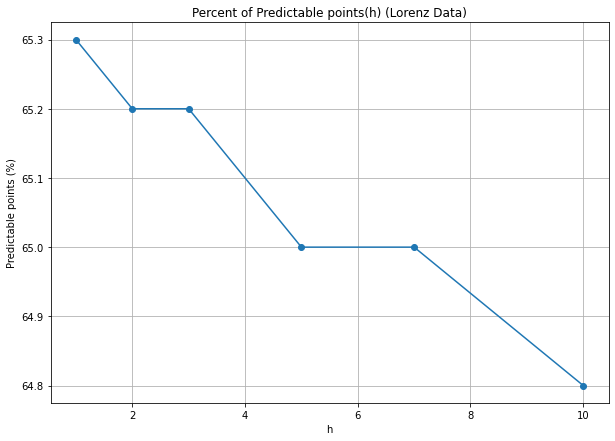

Predicted points Square = 585.35


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('Percent of Predictable points(h) (Lorenz Data)')
plt.plot(h_array, pred_percent_array_lorenz, marker = 'o')
plt.xlabel('h')
plt.ylabel('Predictable points (%)')
plt.grid()
plt.show()

print('Predicted points Square =', np.trapz(pred_percent_array_lorenz, x=h_array))

### Для финансового ряда

In [ ]:
n_fin_train = 2088
n_fin_test = 1000

mu = 0.2  # параметр для определения значимости кластера
k = 6  # ближайший сосед
s = 2  # количество точек в паттерне для предсказания

In [ ]:
data_fin_train = data_fin[:n_fin_train]
data_fin_test = data_fin[n_fin_train:]

In [ ]:
print(len(data_fin_train))
print(len(data_fin_test))

2088
1000


In [ ]:
start_time = time.time()

w_fin = wishart_clustering(data_fin, k, mu)

print("%s seconds" % (time.time() - start_time))

56.850285053253174 seconds


In [ ]:
h_array = [1, 2, 3, 5, 7, 10]
predicted_fin_array = []
for h in h_array:
    start_time = time.time()
    predicted = predict(w_fin, data_fin, n_fin_test, n_fin_train, s, h)
    predicted_fin_array.append(predicted)
    print("%s seconds" % (time.time() - start_time))

0.6958398818969727 seconds
0.7225995063781738 seconds
0.7123608589172363 seconds
0.7259836196899414 seconds
0.7278428077697754 seconds
0.779583215713501 seconds


In [ ]:
plt.figure(figsize = (20, 9))
plt.title('Finance Data prediction for 1 step')
line1, = plt.plot(range(n_fin_train, n_fin_train + n_fin_test), data_fin[n_fin_train:], 'c')
idx = 0
predicted_fin = predict(w_fin, data_fin, n_fin_test, n_fin_train, 3, 1)
for i in range(n_fin_train, n_fin_train + n_fin_test):
    point = predicted_fin_array[0][idx]
    if point is None:
        line2, = plt.plot(i, 0, 'r', marker = 'x')
    else:
        # for x in point:
        #     if x is None:
        #         continue
        #     plt.plot(i, x, 'm', marker = 'o', ms=2)
        mean_point = np.mean(point)
        line3, = plt.plot(i, mean_point, 'm', marker = 'o', ms=3)
    idx += 1
plt.legend([line1, line2, line3], ['Test', 'NP', 'Predicted points'], fontsize=10)
plt.grid()
plt.xlabel('t')
plt.ylabel('Value')
plt.show()

In [ ]:
non_pred_array_fin = []
pred_array_fin = []
for points in predicted_fin_array:
    non_pred_cnt, pred_cnt = amount_of_non_pred_and_pres(points)
    # print(non_pred_cnt, pred_cnt)
    non_pred_array_fin.append(non_pred_cnt)
    pred_array_fin.append(pred_cnt)

np_percent_array_fin = []
pred_percent_array_fin = []
for non_pred in non_pred_array_fin:
    np_percent_array_fin.append((non_pred / n_fin_test) * 100)
for pred in pred_array_fin:
    pred_percent_array_fin.append((pred / n_fin_test) * 100)

In [ ]:
mape_array_fin = []
rmse_array_fin = []
for points in predicted_fin_array:
    p = process_predict_data(points)
    
    mse = mean_squared_error(data_fin_test, p)
    rmse = math.sqrt(mse)
    # print('RMSE:', rmse)
    rmse_array_fin.append(rmse)

    mape = 0.0
    for i in range(n_fin_test):
        if data_fin_test[i] != 0.0:
            mape += math.fabs((data_fin_test[i] - p[i]) / data_fin_test[i])
    res_mape = (1 / n_fin_test) * mape
    # print('MAPE:', res_mape)
    mape_array_fin.append(res_mape)

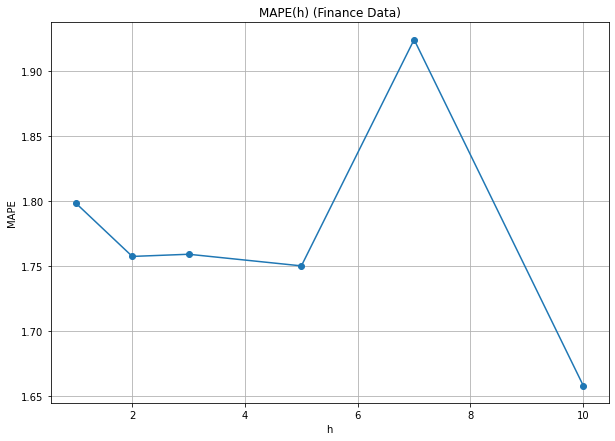

MAPE Square = 16.090874523798508


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('MAPE(h) (Finance Data)')
plt.plot(h_array, mape_array_fin, marker = 'o')
plt.xlabel('h')
plt.ylabel('MAPE')
plt.grid()
plt.show()

print('MAPE Square =', np.trapz(mape_array_fin, x=h_array))

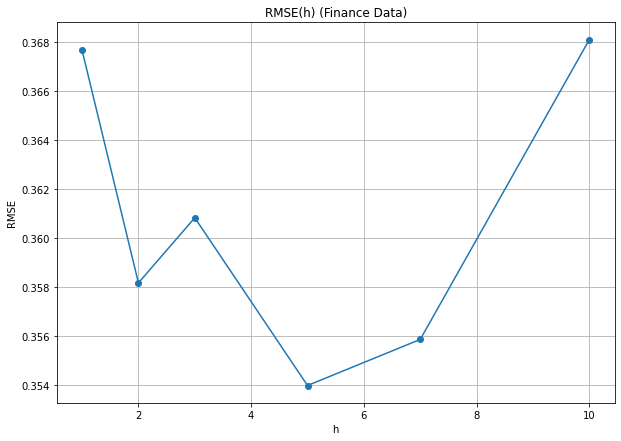

RMSE Square = 3.233022793191567


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('RMSE(h) (Finance Data)')
plt.plot(h_array, rmse_array_fin, marker = 'o')
plt.xlabel('h')
plt.ylabel('RMSE')
plt.grid()
plt.show()

print('RMSE Square =', np.trapz(rmse_array_fin, x=h_array))

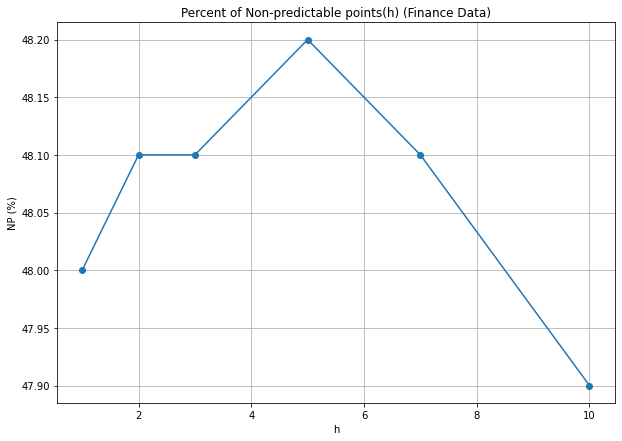

NP Square = 432.75


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('Percent of Non-predictable points(h) (Finance Data)')
plt.plot(h_array, np_percent_array_fin, marker = 'o')
plt.xlabel('h')
plt.ylabel('NP (%)')
plt.grid()
plt.show()

print('NP Square =', np.trapz(np_percent_array_fin, x=h_array))

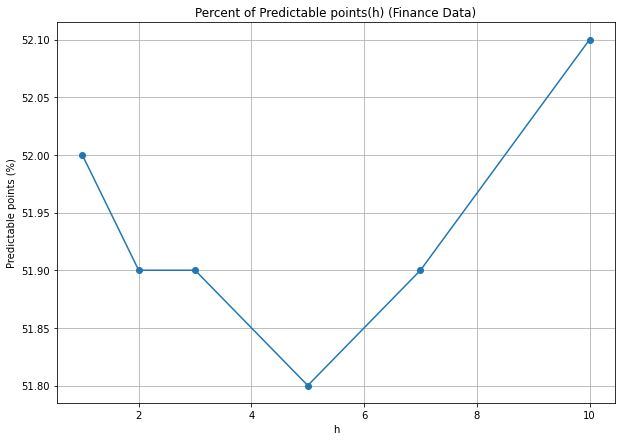

Predicted points Square = 467.25


In [ ]:
plt.figure(figsize = (10, 7))
plt.title('Percent of Predictable points(h) (Finance Data)')
plt.plot(h_array, pred_percent_array_fin, marker = 'o')
plt.xlabel('h')
plt.ylabel('Predictable points (%)')
plt.grid()
plt.show()

print('Predicted points Square =', np.trapz(pred_percent_array_fin, x=h_array))